OSCILADOR ARMÓNICO AMORTIGUADO FORZADO: ¿Cuándo aparece el caos?

In [82]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy as scipy
from math import *
from tqdm import tqdm
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


VALORES NUMÉRICOS DEL PROBLEMA

Condiciones iniciales

In [83]:
x_0 = 10 # Posición inicial (arb)
v_0 = 0 # Velocidad inicial (arb)

Parámetros del sistema

In [84]:
w_0 = 0.5 # Frecuencia natural x>0
amort = 0.125 # constante de amortiguamiento
f_0 = 0.25 # Amplitud de la fuerza por unidad de masa

Frencuencia angular de la fuerza externa

In [85]:
dw = 0.025 # paso en el amortiguamiento
w =  np.array([i*dw for i in range(int(1/dw),int(3/dw)+1)]) # Constante de amortiguamiento
print(w)

[1.    1.025 1.05  1.075 1.1   1.125 1.15  1.175 1.2   1.225 1.25  1.275
 1.3   1.325 1.35  1.375 1.4   1.425 1.45  1.475 1.5   1.525 1.55  1.575
 1.6   1.625 1.65  1.675 1.7   1.725 1.75  1.775 1.8   1.825 1.85  1.875
 1.9   1.925 1.95  1.975 2.    2.025 2.05  2.075 2.1   2.125 2.15  2.175
 2.2   2.225 2.25  2.275 2.3   2.325 2.35  2.375 2.4   2.425 2.45  2.475
 2.5   2.525 2.55  2.575 2.6   2.625 2.65  2.675 2.7   2.725 2.75  2.775
 2.8   2.825 2.85  2.875 2.9   2.925 2.95  2.975 3.   ]


Medida del tiempo

In [86]:
dt = 0.01 # Paso de tiempo
tf = []
t = []
t0 = 0
for i in range(np.size(w)):
    tf.append(5/amort+1000)  # Tiempo de medida (se asume que t0 = 0)
    if tf[i] == inf:
        tf[i] = 1000
    t.append(np.linspace(t0,tf[i],int(tf[i]/dt)+1)) # Vector de instantes de tiempo

Frencuencia angular natural para x<0

In [87]:
dW_0 = 0.1 # paso en la frecuencia natural para x<0
W_0 =  np.array([w_0+i*dW_0 for i in range(int((15*w_0)/dW_0)+1)]) # Frecuencia natural para x<0
print(W_0)

[0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2
 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9 4.
 4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3 5.4 5.5 5.6 5.7 5.8
 5.9 6.  6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8 6.9 7.  7.1 7.2 7.3 7.4 7.5 7.6
 7.7 7.8 7.9 8. ]


DEFINIMOS UNA FRECUENCIA NATURAL DEL OSCILADOR QUE DEPENDE DE LA POSICIÓN

In [88]:
def W(x,W_0): # frecuecia angular
    return W_0 - (W_0-w_0)*np.heaviside(x,w_0)

ECUACIÓN DIFERENCIAL

In [89]:
def EDO(t,y,w,W_0): 
    x,v = y
    # return [v,-2*amort*v-W(x,W_0)**2*x+f_0*np.cos(w*t)] # Classical eqs.
    return [v-amort*x,-W(x,W_0)**2*x-amort*v+f_0*np.cos(w*t)] # Modified eqs.

CÁLCULO DEL EXPONENTE DE LYAPUNOV

Función que calcula el exponente de Lyapunov para unos parámetros del sistema dados

In [90]:
def Lyapunov_exponent(EDO,t,tf,w,W_0,eps,x_0,v_0):

    T = 2*np.pi/w # Periodo fuerza externa

    N = int((tf-t0)/dt)+1
    
    z = np.zeros([N,2])
    zp = np.zeros([N,2])
    d = np.zeros(N)
    loglist = np.zeros(N)

    z[0] = [x_0,v_0]
    zp[0] = [x_0+eps/np.sqrt(2),v_0+eps/np.sqrt(2)]
    d[0] = eps
   
    sol = scipy.integrate.solve_ivp(EDO, [0,tf], z[0], method = 'Radau',t_eval = t,args = [w,W_0])
    pos,vel = sol.y
    solL = scipy.integrate.solve_ivp(EDO, [0,tf], zp[0], method = 'Radau',t_eval = t,args = [w,W_0])
    posL,velL = solL.y
    
    for i in range(1,N):
        z[i] = [pos[i],vel[i]]
        zp[i] = [posL[i],velL[i]]
        d[i] = np.linalg.norm((z[i]-zp[i]))
        loglist[i] = np.log(d[i]/eps)
    
    lyap = np.mean((loglist/t)[-int(N/5):])
    com = scipy.signal.find_peaks(pos)[0][-100:]-scipy.signal.find_peaks(posL)[0][-100:]
    
    if amort != 0:
        if lyap > 0:
            '''
            if abs(np.mean(com)) < 0.1:
                lyap = -lyap
            else:
            '''
            for i in range(1,N):
                d[i] = np.linalg.norm((z[i]-zp[i-round(T/dt)]))
                loglist[i] = np.log(d[i]/eps)
            lyap = np.mean((loglist/t)[-int(N/5):])
            
        if lyap > 0:
            for i in range(1,N):
                d[i] = np.linalg.norm((z[i]-zp[i-2*round(T/dt)]))
                loglist[i] = np.log(d[i]/eps)
            lyap = np.mean((loglist/t)[-int(N/5):])

        if lyap > 0:
            for i in range(1,N):
                d[i] = np.linalg.norm((z[i]-zp[i-3*round(T/dt)]))
                loglist[i] = np.log(d[i]/eps)
            lyap = np.mean((loglist/t)[-int(N/5):])

        if lyap > 0:
            for i in range(1,N):
                d[i] = np.linalg.norm((z[i]-zp[i-4*round(T/dt)]))
                loglist[i] = np.log(d[i]/eps)
            lyap = np.mean((loglist/t)[-int(N/5):])

        if lyap > 0:
            for i in range(1,N):
                d[i] = np.linalg.norm((z[i]-zp[i-5*round(T/dt)]))
                loglist[i] = np.log(d[i]/eps)
            lyap = np.mean((loglist/t)[-int(N/5):])

        if lyap > 0:
            for i in range(1,N):
                d[i] = np.linalg.norm((z[i]-zp[i-6*round(T/dt)]))
                loglist[i] = np.log(d[i]/eps)
            lyap = np.mean((loglist/t)[-int(N/5):])
    
    return [lyap,np.std((loglist/t)[-int(N/5):])]

Cálculo de resultados

In [91]:
lyap = np.zeros([np.size(W_0),np.size(w)])
disp = np.zeros([np.size(W_0),np.size(w)])

eps = 1e-2

for i in tqdm(range(np.size(W_0))):
    for j in range(np.size(w)):
        lyap[i,j],disp[i,j] = Lyapunov_exponent(EDO,t[j],tf[j],w[j],W_0[i],eps,x_0,v_0)

  0%|          | 0/76 [00:00<?, ?it/s]C:\Users\rodri\AppData\Local\Temp\ipykernel_51216\3152266131.py:27: RuntimeWarning: invalid value encountered in divide
  lyap = np.mean((loglist/t)[-int(N/5):])
C:\Users\rodri\AppData\Local\Temp\ipykernel_51216\3152266131.py:72: RuntimeWarning: invalid value encountered in divide
  return [lyap,np.std((loglist/t)[-int(N/5):])]
 13%|█▎        | 10/76 [1:48:39<12:10:35, 664.18s/it]C:\Users\rodri\AppData\Local\Temp\ipykernel_51216\3152266131.py:40: RuntimeWarning: invalid value encountered in divide
  lyap = np.mean((loglist/t)[-int(N/5):])
 16%|█▌        | 12/76 [2:05:58<10:27:00, 587.82s/it]C:\Users\rodri\AppData\Local\Temp\ipykernel_51216\3152266131.py:46: RuntimeWarning: invalid value encountered in divide
  lyap = np.mean((loglist/t)[-int(N/5):])
C:\Users\rodri\AppData\Local\Temp\ipykernel_51216\3152266131.py:52: RuntimeWarning: invalid value encountered in divide
  lyap = np.mean((loglist/t)[-int(N/5):])
C:\Users\rodri\AppData\Local\Temp\ipyker

Almacenamiento de datos

In [92]:
newpath = r'.\explyap' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

for i in range(W_0.size):
    np.savetxt('.\explyap/explyap Ω₀ω₀ = '+str(format(W_0[i]/w_0,'.3f'))+'.txt',lyap[i])

Cargo datos almacenados

In [93]:
lyap_rep = np.zeros([np.size(W_0),np.size(w)])

for i in range(W_0.size):
    f = open('.\explyap/explyap Ω₀ω₀ = '+str(format(W_0[i]/w_0,'.3f'))+'.txt','r')
    lyap_rep[i:] = f.readlines()
    f.close()

Representación gráfica de resultados

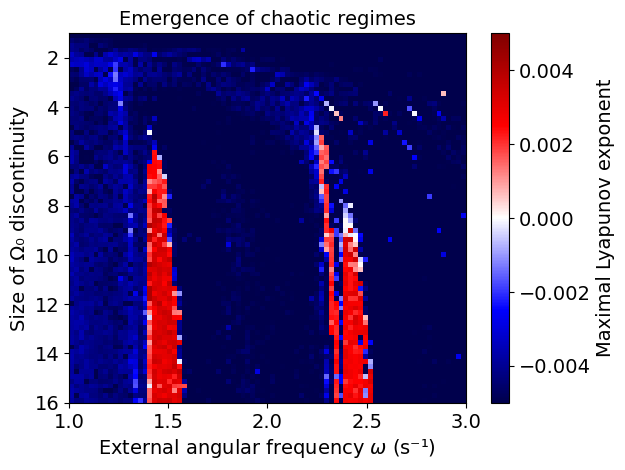

In [97]:
plt.imshow(lyap_rep,cmap = 'seismic',vmin = -0.005, vmax = 0.005, aspect = 'auto', extent = [min(w),max(w),max(W_0)/w_0,1])
cbar = plt.colorbar().set_label(label='Maximal Lyapunov exponent',size=14)
plt.title('Emergence of chaotic regimes',fontsize = 14)
#plt.ylabel('Ω₀(x<0)/Ω₀(x>0)',fontsize = 16)
plt.ylabel('Size of Ω₀ discontinuity',fontsize = 14)
plt.xlabel('External angular frequency $\omega$ (s⁻¹)',fontsize = 14)

plt.savefig('fig_reg.png')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.show()